# Solving Navier-Stokes equations with Adaptive Fourier Neural Operator

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR, StepLR
from fno import AFNO
from losses import LpLoss

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set random seed
torch.manual_seed(0)

## Dataset

In [3]:
data_path = r"ns_data_256_1000_v1e-5.npy"
data = torch.Tensor(np.load(data_path))
# Reduce data size form [1000, 256, 256, 20] -> [2000, 128, 128, 20] by take mean of every 2x2
data = torch.mean(data.view(1000, 128, 2, 128, 2, 20), dim=(2, 4))
data = data.view(1000, 128, 128, 20)
data.shape

torch.Size([1000, 128, 128, 20])

In [5]:
# Split data
train_data = data[:700, ...].reshape(700,   1, 128, 128, 20)
test_data = data[700:900, ...].reshape(200, 1, 128, 128, 20)
eval_data = data[900:, ...].reshape(100,    1, 128, 128, 20)
train_data.shape, test_data.shape, eval_data.shape

(torch.Size([700, 1, 128, 128, 20]),
 torch.Size([200, 1, 128, 128, 20]),
 torch.Size([100, 1, 128, 128, 20]))

In [6]:
# Create data loaders
train_loader = DataLoader(TensorDataset(train_data[:, :, :, :, :10], train_data[:, :, :, :, 10:]), batch_size=1, shuffle=True)
test_loader = DataLoader(TensorDataset(  test_data[:, :, :, :, :10],  test_data[:, :, :, :, 10:]), batch_size=1, shuffle=False)
eval_loader = DataLoader(TensorDataset(  eval_data[:, :, :, :, :10],  eval_data[:, :, :, :, 10:]), batch_size=1, shuffle=False)
train_data[:, :, :, :, :10].shape

torch.Size([700, 1, 128, 128, 10])

## Model

In [7]:
model = AFNO(dim=3,
             max_num_patches=81920,
             in_channels=1,
             patch_size=[2, 2, 2],
             padding=[0, 0, 0],
             out_channels=1,
             num_layers=4, 
             norm_layer=nn.LayerNorm,
             dropcls=0.2).to(device)

## Loss Function

In [8]:
loss_fn = LpLoss(size_average=False)

## Training

In [9]:
# Optimizer
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

In [10]:
# Tensorboard writer
tensorboard_path = "./runs/AFNO3"
writer = SummaryWriter(tensorboard_path)
print("To see the results, run: tensorboard --logdir='{}'".format(tensorboard_path))

To see the results, run: tensorboard --logdir='./runs/AFNO3'


In [11]:
# Training loop
n_epochs = 100

for epoch in range(n_epochs):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        batch_size, n_channels, width, height , time = x.size()
        
        # Forward pass
        y_pred = model(x).reshape(batch_size, n_channels, width, height, time)
        
        # Compute loss
        l2 = loss_fn(y_pred.reshape(batch_size, -1), y.reshape(batch_size, -1))
        
        # Backward pass
        optimizer.zero_grad()
        l2.backward()
        
        # Update weights
        optimizer.step()
        
    # Update learning rate
    scheduler.step()
    model.eval()
    
    # Evaluate model
    with torch.no_grad():
        train_loss, test_loss = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            batch_size, n_channels, width, height, time = x.size()
            
            # Forward pass
            y_pred = model(x).reshape(batch_size, n_channels, width, height, time)
            
            # Compute loss
            train_ls = loss_fn(y_pred.reshape(batch_size, -1), y.reshape(batch_size, -1)).item()
            train_loss.append(train_ls)
            
        # Mean training loss
        train_loss = np.mean(train_loss)
        
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            batch_size, n_channels, width, height, time = x.size()
            
            # Forward pass
            y_pred = model(x).reshape(batch_size, n_channels, width, height, time)
            
            # Compute loss
            test_ls = loss_fn(y_pred.reshape(batch_size, -1), y.reshape(batch_size, -1)).item()
            test_loss.append(test_ls)
            
        
        # Mean test loss
        test_loss = np.mean(test_loss)
        
        # Print losses
        print(f"Epoch {epoch+1}/{n_epochs} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}", end="\r")
        
        # Write to tensorboard
        writer.add_scalars('Loss', {'train': train_loss, 'test': test_loss}, epoch)
        # Write a sample prediction
        writer.add_images('Predictions', y_pred[0, 0, :, :, -1].cpu().numpy(), epoch, dataformats='HW')
        writer.flush()

In [ ]:
# Model evaluation
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        
        break

In [ ]:
x.shape, y.shape, y_pred.shape

(torch.Size([1, 1, 256, 256, 10]),
 torch.Size([1, 1, 256, 256, 10]),
 torch.Size([1, 1, 256, 256, 10]))

In [ ]:
import matplotlib.pyplot as plt

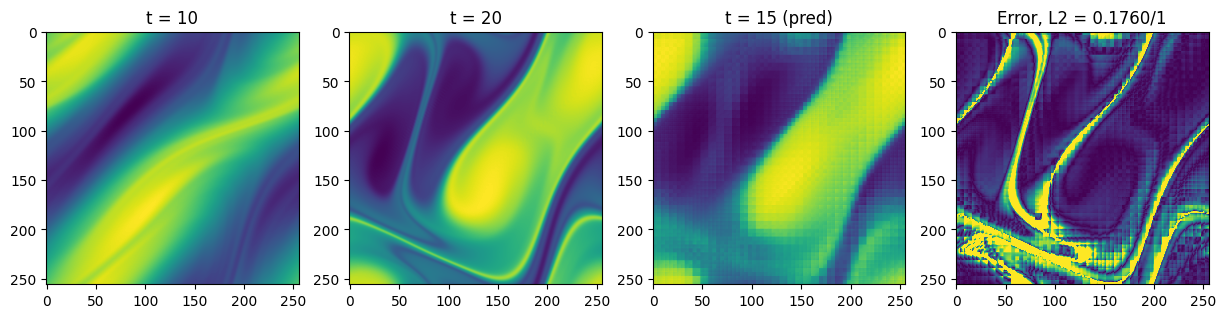

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(x[0, 0, :, :, -1].cpu().numpy())
ax[0].set_title("t = 10")
ax[1].imshow(y[0, 0, :, :, -1].cpu().numpy())
ax[1].set_title("t = 20")
ax[2].imshow(y_pred[0, 0, :, :, -1].cpu().numpy())
ax[2].set_title("t = 15 (pred)")
error = torch.abs(y_pred[0, 0, :, :, -1].cpu() - y[0, 0, :, :, -1].cpu()) / torch.abs(y[0, 0, :, :, -1].cpu())
ax[3].imshow(error, vmin=0, vmax=1)
error = loss_fn(y_pred[0, 0, :, :, :].reshape(1, -1), y[0, 0, :, :, :].reshape(1, -1)).item()
ax[3].set_title("Error, L2 = {:.4f}/1".format(error))
plt.show()

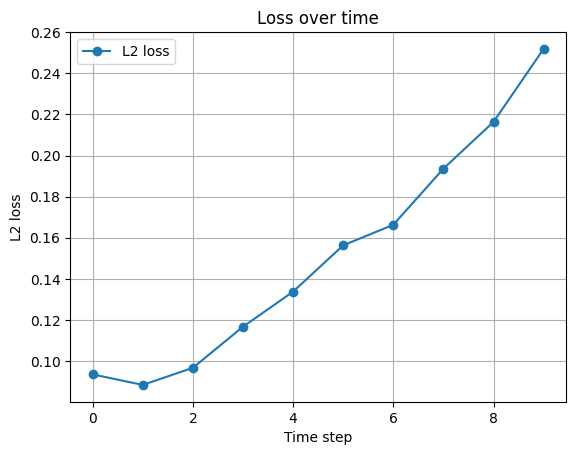

In [ ]:
# Plot loss 
loss_pts = []
for i in range(x.size()[-1]):
    loss_pt = loss_fn(y_pred[0, :, :, :, i].reshape(1, -1), y[0, :, :, :, i].reshape(1, -1)).item()
    loss_pts.append(loss_pt)
    
plt.plot(loss_pts, 'o-', label="L2 loss")
plt.xlabel("Time step")
plt.ylabel("L2 loss")
plt.title("Loss over time")
plt.legend()
plt.grid()
plt.show()